## Placid Money -- Recruitment Test 4 -- Arsenii Turyshev 

In [1]:
import pandas as pd
import numpy as np

In [211]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
uw = pd.read_excel('underwriting_details.xlsx').set_index('id')

In [14]:
# some users are missing FICO
uw = uw[uw.fico_score > 0]

In [15]:
uw = uw.sort_values('created_at')
uw.head()

,user_id,created_at,report_id,result,fico_score,hit_code,fraud_id,vantage_score
id,,,,,,,,
196,895,2021-09-19 08:34:45.655,206.0,Approved,649.0,1.0,1,NaN
205,922,2021-09-20 11:54:00.095,215.0,Approved,587.0,1.0,5,NaN
219,653,2021-09-21 22:19:22.388,229.0,Approved,604.0,1.0,5,NaN
233,1042,2021-09-23 06:51:40.657,243.0,Approved,607.0,6.0,L,NaN
236,1052,2021-09-23 09:50:12.250,246.0,Approved,538.0,1.0,R,NaN


In [20]:
user_base = uw.groupby('user_id').tail(1).set_index('user_id')[['created_at', 'fico_score']]

In [21]:
# normalize FICO
user_base['fico_score'] = (user_base['fico_score'] - 300) / (850 - 300)

In [22]:
user_base.head()

,created_at,fico_score
user_id,,
1699,2021-10-11 01:08:20.069,0.474545
1845,2021-12-21 04:47:02.283,0.609091
4890,2021-12-29 01:03:58.355,0.667273
5283,2022-01-13 12:12:42.369,0.643636
5404,2022-01-17 11:01:21.774,0.661818


In [163]:
ch = pd.read_excel('credit_card_accounts_history.xlsx')

In [164]:
# slice the last column into two dates
ch['start_period'] = pd.to_datetime(ch.sys_period.str.slice(2,12))
ch['end_period'] = pd.to_datetime(ch.sys_period.str.split(',').str[-1].str.slice(1,11))
ch['period_days'] = (ch['end_period'] - ch['start_period']).dt.days

In [165]:
pd.set_option('display.max_rows', None)

In [166]:
ch[['user_id', 'current_balance', 'limit', 'current_utilization', 'start_period', 'end_period', 'period_days']].head()

,user_id,current_balance,limit,current_utilization,start_period,end_period,period_days
0,3894,45724,50000,91.4480,2022-02-18,2022-02-18,0
1,3894,445648,450000,99.0329,2022-02-18,2022-02-18,0
2,6595,40648,700000,5.8069,2022-02-18,2022-02-18,0
3,201,93183,100000,93.1830,2022-02-18,2022-02-19,1
4,201,763905,780000,97.9365,2022-02-18,2022-02-19,1


In [167]:
# omit rows with period_days = 0
ch = ch[ch.period_days > 0].sort_values(['id', 'start_period'])

In [168]:
all_cards = ch[['id', 'user_id']].drop_duplicates().set_index('id')

In [169]:
g = cards_utlzn.groupby('id')
all_cards['history_days'] = g.period_days.sum()

In [170]:
def dot_product(df, idx, column1, column2):
    return pd.Series({id: np.dot(df[df.id == id][column1], df[df.id == id][column2]) for id in idx})

In [171]:
# calculate average utilization rate
all_cards['avg_utlzn'] = dot_product(ch, all_cards.index, 'current_utilization', 'period_days') / all_cards['history_days']

In [172]:
# now we calculate average card limit and apr (in rare cases they change)
all_cards['limit'] = dot_product(ch, all_cards.index, 'limit', 'period_days') / all_cards['history_days']
all_cards['apr'] = dot_product(ch, all_cards.index, 'apr', 'period_days') / all_cards['history_days']

In [173]:
# number of days when current_utilization is higher than X
ch['cu25+'] = (ch.current_utilization >= 25)
ch['cu50+'] = (ch.current_utilization >= 50)
ch['cu75+'] = (ch.current_utilization >= 75)
ch['cu100+'] = (ch.current_utilization >= 100)
ch['cu125+'] = (ch.current_utilization >= 125)

In [174]:
all_cards['cu25+'] = dot_product(ch, all_cards.index, 'cu25+', 'period_days') / all_cards['history_days']
all_cards['cu50+'] = dot_product(ch, all_cards.index, 'cu50+', 'period_days') / all_cards['history_days']
all_cards['cu75+'] = dot_product(ch, all_cards.index, 'cu75+', 'period_days') / all_cards['history_days']
all_cards['cu100+'] = dot_product(ch, all_cards.index, 'cu100+', 'period_days') / all_cards['history_days']
all_cards['cu125+'] = dot_product(ch, all_cards.index, 'cu125+', 'period_days') / all_cards['history_days']

In [190]:
all_cards.head()

,user_id,history_days,avg_utlzn,limit,apr,cu25+,cu50+,cu75+,cu100+,cu125+
id,,,,,,,,,,
57,201,218,99.802397,1.120000e+06,22.99,1.000000,1.000000,1.000000,0.669725,0.0
58,201,266,90.971933,9.197368e+05,0.00,1.000000,1.000000,1.000000,0.000000,0.0
59,213,217,101.398600,2.100000e+05,19.24,1.000000,1.000000,1.000000,1.000000,0.0
116,201,236,42.167140,1.000000e+05,23.99,0.516949,0.483051,0.368644,0.000000,0.0
117,201,240,95.898570,7.800000e+05,25.24,1.000000,0.991667,0.954167,0.483333,0.0


In [193]:
# aggregation by user (using "max" for simplicity)
final_df = all_cards.groupby('user_id').agg('max')
final_df['count_cards'] = all_cards.groupby('user_id').agg('count').limit
final_df = final_df.join(user_base[['fico_score']]).dropna()

In [194]:
final_df.head()

,history_days,avg_utlzn,limit,apr,cu25+,cu50+,cu75+,cu100+,cu125+,count_cards,fico_score
user_id,,,,,,,,,,,
201,266,99.802397,1120000.0,25.240000,1.0,1.0,1.0,0.669725,0.000000,4,0.276364
205,161,109.940100,31891.0,24.000000,1.0,1.0,1.0,1.000000,0.000000,1,0.214545
213,220,101.398600,360000.0,19.240000,1.0,1.0,1.0,1.000000,0.000000,2,0.298182
377,193,132.301036,60000.0,24.740000,1.0,1.0,1.0,1.000000,0.502591,3,0.378182
408,195,104.210820,418339.0,23.999511,1.0,1.0,1.0,0.959770,0.000000,4,0.270909


In [197]:
from optbinning import ContinuousOptimalBinning as optb

In [212]:
vars_df = pd.DataFrame(columns=['Variable', 'IV', 'WOE'])
for c in final_df.columns[:-1]:
    v = optb(dtype='numerical')
    v.fit(final_df[c], final_df.fico_score)
    bt = v.binning_table
    bt.build()
    vars_df = vars_df.append({'Variable': c, 'IV': bt.iv, 'WOE': bt.woe}, ignore_index=True)

In [216]:
vars_df.sort_values('IV', ascending=False)

,Variable,IV,WOE
7,cu100+,0.117639,1.485513
0,history_days,0.115046,2.340077
1,avg_utlzn,0.11126,1.94165
6,cu75+,0.108422,1.827827
5,cu50+,0.095982,1.463168
4,cu25+,0.078977,1.476985
2,limit,0.073786,1.648194
3,apr,0.064364,1.45192
9,count_cards,0.050767,1.299688
8,cu125+,0.05025,1.102713


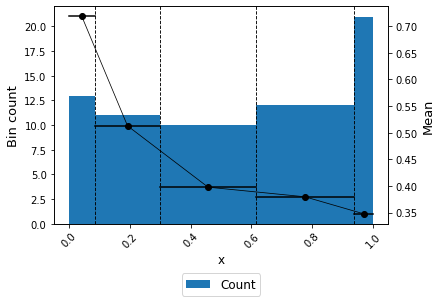

In [219]:
var1 = optb(dtype='numerical')
var1.fit(final_df['cu100+'], final_df.fico_score)
var1.binning_table.build()
var1.binning_table.plot(style='actual')

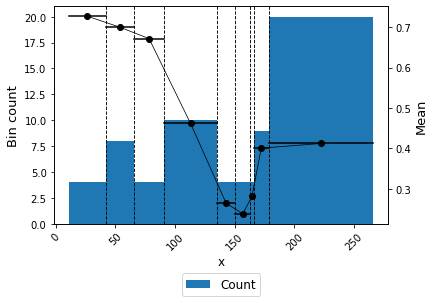

In [220]:
var1 = optb(dtype='numerical')
var1.fit(final_df['history_days'], final_df.fico_score)
var1.binning_table.build()
var1.binning_table.plot(style='actual')

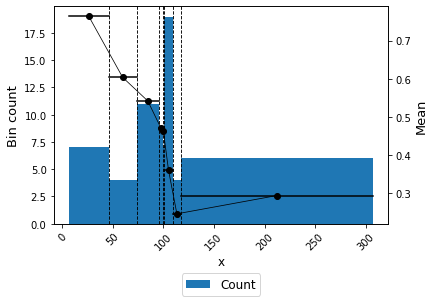

In [221]:
var1 = optb(dtype='numerical')
var1.fit(final_df['avg_utlzn'], final_df.fico_score)
var1.binning_table.build()
var1.binning_table.plot(style='actual')